<div style="text-align: right"> Warszawa 06.01.2021 </div>
<h2 style="text-align: center"> Programowanie równoległe i rozproszone </h2>
<h3 style="text-align: center"> Zadanie projektowe nr 3</h3>

Prowadzący:
- dr Bartłomiej Kubica

Wykonujący projekt:
- Jan Gołda
- Michał Maciołek

<br><br><br>

# 1. Wprowadzenie

Celem projektu jest implementacja procedury równoległej symulacji N ciał, oddziałujących na siebie grawitacyjnie w trójwymiarowej przestrzeni (ang. N-body problem). Zakładamy, że ciała są na tyle małe, że możemy pominąć ich zderzenia. Procedura powinna śledzić zmieniające się co krok czasowy $\delta t$ parametry każdego ciała takie jak: 
- Położenie,
- Prędkość,
- Przyspieszenie.

Powyższe wartości można wyliczać za pomocą prostego w implementacji algorytmu siłowego. Każde z $N$ ciał oddziaływuje na pozostałe $N-1$, czyli podczas każdej iteracji następuje $N(N-1)$ interakcji między ciałami. Wadą tego rozwiązania jest wysoki koszt obliczeń - $O(N^{2})$. Złożoność dokładnej symulacji (o małym kroku czasowym $\delta t$) zawierającej wiele ciał (duża wartość $N$) jest w tym przypadku ogromna. Aby zwiększyć efektywność symulacji, możliwe jest  równoległe wykonywanie pewnych procesów składowych procedury. Natomiast, żeby zmniejszyć złożoność obliczeniową możemy wykorzystać algorytmy wydajniejsze niż algorytm siłowy. Są to np:

- algorytm Barnes-Hut,
- FMM (ang. Fast Multipole Method),
- PMTA (ang. Parallel Multipole Tree Algorithm)

Metody te polegają na reprezentacji ciał w przestrzeni za pomocą drzewa ósemkowego (drzewa czwórkowego jeśli uniwersum ma dwa wymiary). Ich oszczędność obliczeniowa wywodzi się z założenia, że przy spełnieniu odpowiednich wymagań możemy potraktować zbiór ciał jako jeden obiekt o masie równej sumie mas ciał składowych oraz środku masy będącym średnią ważoną współrzędnych ciał składowych i ich mas. Dzięki temu uproszczeniu w przypadku np. algorytmu "Barnes-Hut" złożoność obliczeniowa maleje do $O(Nlog(N))$. Algorytm ten jest bardzo efektywny w przypadku oddziaływań grawitacyjnych, lecz w przypadku oddziaływań elektrostatycznych korzystniejsze jest użycie metod "FMM" lub "PMTA". Wszystkie trzy metody można skutecznie zrównoleglić. 

Zakres projektu obejmuje implementacje algorytmu siłowego oraz "Barnes-Hut", zrównoleglenie z pamięcią wspólną oraz rozproszoną, a także wizualizację symulacji. 

# 2. Algorytm Barnes-Hut
<br>

Każda iteracja algorytmu "Barnes-Hut" składa się z dwóch faz:
- Tworzenie drzewa zawierającego ciała uniwersum,
- Obliczanie oddziaływań między ciałami.

### Tworzenie drzewa
Na początku symulacji posiadamy trójwymiarowe uniwersum, w którym znajduje się $N$ ciał o losowych współrzędnych. Budowanie drzewa w algorytmie "Barnes-Hut" polega na rekursywnym dzieleniu przestrzeni na sześcienne sekcje tak długo, aż w każdej sekcji znajdować się będzie maksymalnie jedno ciało.

Dla trójwymiarowej przestrzeni konstruowane drzewo jest drzewem ósemkowym. Węzeł główny oznacza sześcian obejmujący wszystkie ciała znajdujące się w uniwersum. Następnie jest on dzielony na osiem równych sześcianów, gdzie każdy z nich stanowi jeden węzeł podrzędny. Jeśli któryś z tych ośmiu sześcianów obejmuje więcej niż jedno ciało, zostaje on rekursywnie dzielony na kolejne osiem sześcianów, aż każde ciało będzie w osobnej sekcji. Węzły wewnętrzne zawierają informacje o łącznej masie oraz środku masy wszystkich ciał znajdujących się w poddrzewie tworzonym przez ten węzeł wewnętrzny.

Następujący rysunek obrazuje reprezentacje uniwersum za pomocą drzewka ósemkowego:

<img src="https://maciolek-demo.s3.eu-central-1.amazonaws.com/michalszescian.png" width="500" height="600">

W momencie kiedy został utworzony węzeł główny wraz z ośmioma węzłami podrzędnymi, możemy przystąpić do umieszczania ciał uniwersum do drzewa, każdego po kolei według następującego schematu.

Próbujemy umieścić ciało $a$ w drzewie o węźle głównym $x$:

1. Jeśli węzeł x jest węzłem zewnętrznym i nie zawiera żadnego ciała, umieść w nim ciało $a$.
2. Jeśli węzeł $x$ jest węzłem wewnętrznym, zaktualizuj jego łączną masę i środek masy biorąc pod uwagę ciało $a$, a następnie rekursywnie umieść ciało $a$ w jednym z jego ośmiu węzłów podrzędnych.
3. Jeśli węzeł x jest węzłem zewnętrznym zawierającym już jakieś ciało, załużmy ciało $b$, to przekształć go w węzeł wewnętrzny z ośmioma węzłami podrzędnymi. Następnie ustal masę oraz środek masy tego węzła wewnętrznego biorąc pod uwagę ciała $a$ oraz $b$. Potem umieść te dwa ciała w odpowiednich węzłach podrzędnych. Jeśli ciała ponownie znajdą się w obszarze jednego węzła zewnętrznego, powtórz ten krok.

Po umieszczeniu wszystkich ciał w drzewie można przejść do drugiej fazy algorytmu - obliczania oddziaływań między ciałami.

### Obliczanie oddziaływań między ciałami

Aby obliczyć siłę, z jaką ciało $a$ jest przyciągane przez inne ciało lub zbiór ciał, należy postępować zgodnie z poniższym algorytmem zaczynając od węzła głównego:

1. Jeśli rozpatrywany węzeł zawiera tylko jedno ciało (różne od ciała $a$), załużmy ciało $b$ to oblicz siłę z jaką przyciąga ono ciało $a$ i dodaj ją do wszystkich sił działających na ciało $a$.
2. Jeżeli rozpatrywany węzeł jest węzłem wewnętrznym i $\frac{s}{d} < \theta$, to możemy potraktować ciała znajdujące się w poddrzewie  tworzonym przez ten węzeł  jako jeden obiekt oddziałujący na ciało $a$. Masa tego obiektu to łączna masa wszystkich ciał składowych, a środek masy to średnia ważona współrzędnych tych ciał i ich mas. 
3. Jeśli węzeł jest węzłem wewnętrznym, ale $\frac{s}{d} \geq \theta$ to należy obliczyć oddziaływania wszystkich jego węzłów podrzędnych na ciało $a$ z osobna. <br><br>

$s$ - szerokość sześcianu reprezentowanego przez węzeł <br><br>
$d$ - odległość między ciałami / odległość między ciałem a środkiem masy zbioru ciał <br><br>
$\theta$ - parametr określający precyzję algorytmu "Barnes-Hut". Jeśli ustalimy jego wartość jako bardzo małą to praktycznie żaden zbiór ciał nie będzie mógł zostać potraktowany jako jeden obiekt i liczba interakcji wyniesie $N(N-1)$. W tym przypadku złożoność obliczeniowa algorytmu "Barnes-Hut" będzie taka sama jak algorytmu siłowego.

# 3. Wykorzystane wzory

Siła z jaką oddziałowują na siebie grawitacyjnie ciało $i$ oraz $j$:

<center>$F = G · m_{i} · m_{j} · \frac {r_{j} - r_{i}}{|r_{j} - r_{i}|^{3}}$</center>

Zgodnie z II zasadą dynamiki Newtona, jeśli na ciało działają niezrównoważone siły to ciało to porusza się z przyspieszeniem wprost proporcjonalnym do siły wypadkowej, a odwrotnie proporcjonalnym do masy ciała. Dzięki temu po obliczeniu wypadkowej siły działącej na ciało możemy określić przyspieszenie z jakim się porusza.

<center>$F = a_{i}m_{i}$</center> <br>
<center>$a_{i} = \frac{F}{m_{i}}$</center><br>
<center>$a_{i}  = G · m_{j} · \frac {r_{j} - r_{i}}{|r_{j} - r_{i}|^{3}}$</center><br>

Przyspieszenie te powoduje zmiane prędkości oraz położenia:
<br><br>
<center>$v_{i} = v_{i} + \frac {\Delta t}{2} · a_{i}$</center> <br>
<center>$r_{i} = r_{i} + \Delta t · v_{i}$</center> <br>

$F$ - siła grawitacji z jaką oddziałowują na siebie dwa ciała $[N]$ <br><br>
$G$ - stała grawitacyjna. W układzie SI ma wartość $6.67259 · 10^{-11} [N \frac{m^{2}}{kg^{2}}]$<br><br>
$a_{i}$ - przyspieszenie z jakim porusza się ciało $i$ $[\frac{m}{s^{2}}]$<br><br>
$m_{i}$ - masa ciała $i$ $[kg]$<br><br>
$v_{i}$ - prędkość z jaką porusza się ciało $i$ $[\frac{m}{s}]$<br><br>
$r_{i}$ - położenie ciała $i$ $[m]$<br>

# 4. Implementacja

Podczas trwania procedury informacje na temat ciał znajdujących się w uniwersum oraz dane na temat węzłów reprezentowane są za pomocą macierzy zawierającej typy liczbowe. W przypadku podejścia sekwencyjnego jest możliwość obrania bardziej obiektowej implementacji, jednakże rozwiązanie macierzowe jest niezbędne w celu zwrównoleglenia procedury symulującej. Macierz z parametrami składa się z następujących macierzy składowych:

- $pozycjeCiał = $&nbsp;$ [$&nbsp;$[r_{x, 0}, $&nbsp;$ r_{y, 0}, $&nbsp;$ r_{z, 0}],$&nbsp;$ $&nbsp;$ [r_{x, 1}, $&nbsp;$ r_{y, 1}, $&nbsp;$ r_{z, 1}],$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ [r_{x, n-1}, $&nbsp;$ r_{y, n-1}, $&nbsp;$ r_{z, n-1}]$&nbsp;$]$ <br><br>

- $prędkościCiał = $&nbsp;$ [$&nbsp;$[v_{x, 0}, $&nbsp;$ v_{y, 0}, $&nbsp;$ v_{z, 0}],$&nbsp;$ $&nbsp;$ [v_{x, 1}, $&nbsp;$ v_{y, 1}, $&nbsp;$ v_{z, 1}],$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ [v_{x, n-1}, $&nbsp;$ v_{y, n-1}, $&nbsp;$ v_{z, n-1}]$&nbsp;$]$ <br><br>

- $przyspieszeniaCiał = $&nbsp;$ [$&nbsp;$[a_{x, 0}, $&nbsp;$ a_{y, 0}, $&nbsp;$ a_{z, 0}],$&nbsp;$ $&nbsp;$ [a_{x, 1}, $&nbsp;$ a_{y, 1}, $&nbsp;$ a_{z, 1}],$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ [a_{x, n-1}, $&nbsp;$ a_{y, n-1}, $&nbsp;$ a_{z, n-1}]$&nbsp;$]$ <br><br>

- $masyCiał = $&nbsp;$ [$&nbsp;$m_{0},$&nbsp;$ $&nbsp;$ m_{1},$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ m_{n-1}$&nbsp;$]$ <br><br>

- $pozycjeWęzłów = $&nbsp;$ [$&nbsp;$[d_{x, 0}, $&nbsp;$ d_{y, 0}, $&nbsp;$ d_{z, 0}],$&nbsp;$ $&nbsp;$ [d_{x, 1}, $&nbsp;$ d_{y, 1}, $&nbsp;$ d_{z, 1}],$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ [d_{x, k-1}, $&nbsp;$ d_{y, k-1}, $&nbsp;$ d_{z, k-1}]$&nbsp;$]$ <br><br>

- $masyWęzłów = $&nbsp;$ [$&nbsp;$w_{0},$&nbsp;$ $&nbsp;$ w_{1},$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ w_{k-1}$&nbsp;$]$ <br><br>

- $wymiaryWęzłów = $&nbsp;$ [$&nbsp;$s_{0},$&nbsp;$ $&nbsp;$ s_{1},$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ s_{k-1}$&nbsp;$]$ <br><br>

- $typyWęzłówPodrzędnych = $&nbsp;$ [$&nbsp;$[c_{0, 0}, $&nbsp;$ c_{0, 1}, $&nbsp;$ ..., $&nbsp;$ c_{0, 7}], $&nbsp;$ $&nbsp;$ [$&nbsp;$[c_{1, 0}, $&nbsp;$ c_{1, 1}, $&nbsp;$ ..., $&nbsp;$ c_{1, 7}],$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ [$&nbsp;$[c_{k-1, 0}, $&nbsp;$ c_{k-1, 1}, $&nbsp;$ ..., $&nbsp;$ c_{k-1, 7}]$ <br><br>

- $idWęzłówPodrzędnych = $&nbsp;$ [$&nbsp;$[i_{0, 0}, $&nbsp;$ i_{0, 1}, $&nbsp;$ ..., $&nbsp;$ i_{0, 7}], $&nbsp;$ $&nbsp;$ [$&nbsp;$[i_{1, 0}, $&nbsp;$ i_{1, 1}, $&nbsp;$ ..., $&nbsp;$ i_{1, 7}],$&nbsp;$ $&nbsp;$ ... $&nbsp;$, $&nbsp;$ $&nbsp;$ [$&nbsp;$[i_{k-1, 0}, $&nbsp;$ i_{k-1, 1}, $&nbsp;$ ..., $&nbsp;$ i_{k-1, 7}]$ <br><br>

$n$ - łączna liczba ciał  $[-]$ <br><br>
$k$ - łączna liczba węzłów  $[-]$ <br><br>
$r_{x, j}$ - położenie ciała $j$ względem osi x  $[m]$<br><br>
$v_{x, j}$ - prędkość ciała $j$ względem osi x  $[\frac {m}{s}]$<br><br>
$a_{x, j}$ - przyspieszenie ciała $j$ względem osi x  $[\frac{m}{s^{2}}$] <br><br>
$m_{j}$ - masa ciała $j$  $[kg]$<br><br>
$d_{x, j}$ - położenie węzła $j$ względem osi x  $[m]$ <br><br>
$w_{j}$ - łączna masa węzła $j$  $[kg]$<br><br>
$s_{j}$ - szerokość sześcianu reprezentowanego przez węzeł $j$  $[m]$ <br><br>
$c_{j, p}$ - typ węzła podrzędnego o numerze $p$ węzła $j$. Może przyjmować wartości:<br><br> 0 (pusty węzeł), 1 (węzeł zewnętrzny zawierający ciało), 2 (węzeł wewnętrzny)<br><br>
$i_{j, p}$ - identyfikator węzła podrzędnego o numerze $p$ węzła $j$  $[-]$<br><br>

### Zrównoleglenie z pamięcią wspólną

Dzięki powyższemu zapisowi macierzowemu jesteśmy w stanie zaimplementować procedurę równoległą z pamięcią wspólną, składającą się z trzech etapów (w każdej iteracji symulacji) które zostały opisane poniżej.

Warto zwrócić uwagę na to, że wykorzystany sposób zapisu macierzowego pozwala nam na pominięcie (za wyjątkiem jednego licznika) mechanizmów synchronizacji, ponieważ nigdy nie może dojść do sytuacji w której dwa procesy modyfikują pamięć z której korzysta inny proces.

#### 1. Budowa drzewa ósemkowego
Proces główny wypełnia pierwsze dwie warstwy węzłów drzewa, tworząc tym samym $1+8$ węzłów, a następnie zleca konstrukcję poszczególnych gałęzi zaczynających się w warstwie trzeciej. Tym samym generowane są $64$ zadania, które rozdzielane są pomiędzy procesy.

#### 2. Obliczanie sił działających na ciała
Proces główny rodziela zadanie aktualizacji przysieszenia ciała pomiędzy procesy potomne. Każdy process realizuje algorytm Barnes-Hut korzystając z informacji przechowywanych w pamięci współdzielonej i aktualizuje przyspieszenie przypisanych do niego ciał.

#### 3. Aktualizacja prędkości i pozycji
Podobnie jak w poprzednim kroku zadania aktualizacji położenia ciał są rozdzielane pomiędzy procesy

### Zrównoleglenie z pamięcią rozproszoną

Procedura równoległa z pamięcią rozproszoną w przypadku implentacji zawartej w tym projekcie składa się z następujących etapów podczas każdej iteracji:

1. Tworzenie drzewa w sposób sekwencyjny
2. Równoległe obliczanie przyspieszeń
3. Równoległa aktualizacja pozycji wszystkich ciał znajdujących się w uniwersum.


Pierwszym krokiem każdej iteracji symulacji jest propagacja wszystkich danych niezbędnych do obliczeń do każdego procesu.

Następnie zostają ustalone porcje obliczeń przysługujące każdemu węzłowi. Potem następuje sekwencyjne zbudowanie drzewa przez proces zerowy.

Później, każdy proces oblicza przyspieszenia dla przydzielonych mu ciał i dzieli się wynikami ze wszystkimi pozostałymi węzłami. 

W ten sposób każdy z procesów jest w posiadaniu kompletnych, obliczonych przyspieszeń.

Następnie węzły w podobny sposób aktualizują prędkości ciał, a później położenia ciał. Mianowicie, każdy proces wykonuje swoją część pracy i udostępnia wyniki pozostałym węzłom.

# 5. Wizualizacja

Poniższa animacja przedstawia wizualizacje symulacji wzajemnego oddziaływania 30 ciał. Wizualizację tą można uruchomić wywołując komendę:

```bash
python main.py --method sequential --distribution center-of-mass --bodies 30 --show_trails
```

<img src="https://maciolek-demo.s3.eu-central-1.amazonaws.com/wizualizacja.gif" width="1100" height="620">

# 6. Testy

W celu weryfikacji rozwiązania wykonaliśmy dwa typy testów.

## Testy poprawności

Jeżeli idzie o poprawność fizyczną naszej symulacji uznaliśmy, że nie jest to kluczowy aspekt tego projektu, dlatego tą część algorytmu testowaliśmy jedynie empirycznie, poprzed obserwację zachowania ciał na wizualizacji.

Obserwacja potwierdziła że ciała poprawnie oddziałowywują na siebie w każdej z trzech implementacji (brute-force, sekwencyjna, zrównloeglona).

## Testy wydajności

W celu weryfikacji oczekiwanego przyspieszenia pomiędzy kolejnymi implementacjami porównaliśmy uśrednione czasy wykonania jednej iteracji symulacji dla każdej z nich. 

Testy te wykonane zostały na maszynie z 80 rdzeniami, dzięki czemu możemy wyraźnie zobrazować jak skaluje się nasze rozwiązanie wraz ze wzrostem mocy obliczeniowej.

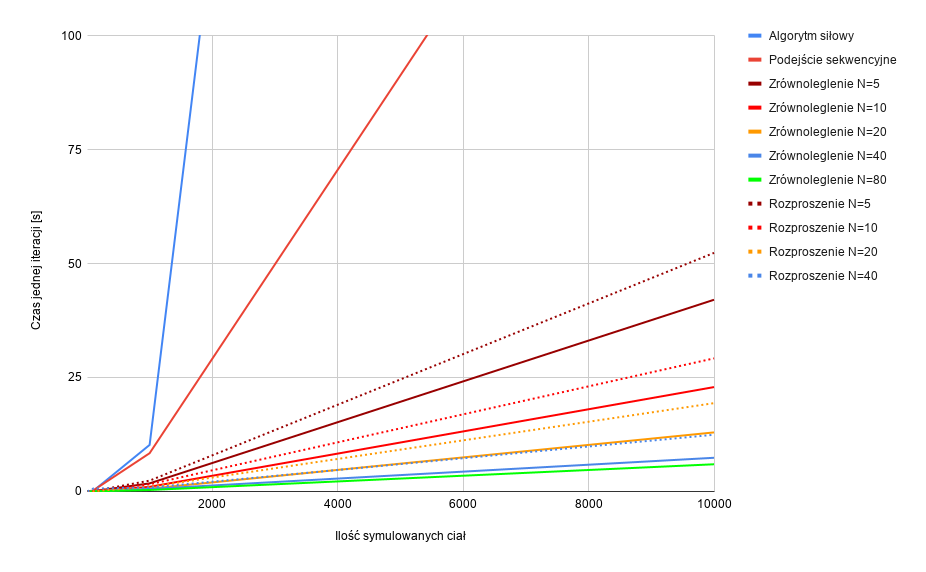

# 7. Wnioski
Zastosowanie zrównolegleń, zarówno z pamiecią wspólną jak i rozproszoną powoduje znączącą poprawę wydajności algorytmu "Barnes-Hut". 

Wartość przyspieszenia dla obu tych metod jest porównywalna, jednakowoż wykorzystanie zrównoleglenia z pamiecią wspólną wydaje się być optymalnym rozwiązaniem. Jest to spowodowane duża ilością danych (cały graf metody Barnes-Hut) które muszą zostać przesłane do każdego procesu w przypadku rozproszenia.

# 8. Zalecany sposób urzycia 

Nasza implementacja wymaga Python'a w wersji `3.8.2+` (z racji na wykorzystanie `SharedMemoryManager`) oraz instalacji potrzebnych bibliotek:

```bash
pip install -r requirements.txt
```

Pełny opis opcji dostępny jest po wywołaniu:

```bash
python main.py --help
```

Przykładowe wywołania:
```bash
python main.py --method sequential --distribution center-of-mass --bodies 30 --show_trails
python main.py --method parallel --distribution center-of-mass --bodies 100 --benchmark --benchmark_steps 5
mpiexec -n 10 python main.py --method distributed --distribution center-of-mass --bodies 100 --benchmark
```

# 9. Źródła

[1] Guy Blelloch and Girija Narlikar - "A Practical Comparison of N-Body Algorithms" http://www.cs.cmu.edu/afs/cs.cmu.edu/project/scandal/public/papers/dimacs-nbody.pdf?fbclid=IwAR36c0UtL1vIViYq7b4ssUiFAjTptnZRoq-mHoPwJMkUSy0pP7zmeb0EImY <br>
[2] Tom Ventimiglia and Kevin Wayne - "The Barnes-Hut Algorithm" http://arborjs.org/docs/barnes-hut?fbclid=IwAR0VIVp19gbFyhBr6F1A84UjO5pwuDyG2sHcimN6SPwzWJrzAd4DkjKR5e0 <br>